In [1]:
import os
import random
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from tqdm import tqdm
import glob
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import timm
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from sklearn.metrics import r2_score

In [2]:
############# Path Configuration #############
DATA_STRUCTURE_PATH = "/kaggle/input/muen-structure/download_checkpoint_muen_old.json"
IMAGE_BASE_DIR = "/kaggle/input/muenchen-data/muenchen_images"
MODELS_DIR = "best_regression_model_muenchen.pth"

NUM_EPOCHS_1 = 4
NUM_EPOCHS_2 = 2

In [3]:
def set_seed():
    seed = 28
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
set_seed()

In [4]:
# GPU Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [5]:
class StreetViewDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['image_path']
        label = self.dataframe.iloc[idx]['label']
        
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

# Classification Model
class EfficientNetClassifier(nn.Module):
    def __init__(self, num_classes=10, model_name='efficientnet_b3'):
        super(EfficientNetClassifier, self).__init__()
        
        self.backbone = timm.create_model(model_name, 
                                         pretrained=True,
                                         num_classes=0,
                                         global_pool='avg')
        
        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(self.backbone.num_features, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )
        
    def forward(self, x):
        features = self.backbone(x)
        output = self.classifier(features)
        return output

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, scheduler=None):
    model = model.to(device)
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    best_val_accuracy = 0.0
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        
        for images, labels in tqdm(train_loader):
            
            images = images.to(device)
            labels = labels.long().to(device)
            
            # Forward pass
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            # Calculate training accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
            
            running_loss += loss.item() * images.size(0)
            
            # Update progress bar with current metrics
            current_acc = 100 * correct_train / total_train
        
        # Calculate epoch training metrics
        epoch_train_loss = running_loss / len(train_loader.dataset)
        epoch_train_acc = 100 * correct_train / total_train
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                
                images = images.to(device)
                labels = labels.long().to(device)
                
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                
                # Calculate validation accuracy
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
        
        # Calculate epoch validation metrics
        epoch_val_loss = val_loss / len(val_loader.dataset)
        epoch_val_acc = 100 * correct_val / total_val
        
        # Store metrics
        train_losses.append(epoch_train_loss)
        val_losses.append(epoch_val_loss)
        train_accuracies.append(epoch_train_acc)
        val_accuracies.append(epoch_val_acc)
        
        # Step scheduler
        if scheduler:
            scheduler.step()
        
        # Print detailed epoch summary
        print(f'\nEpoch {epoch+1}/{num_epochs}:')
        print(f'  Train Loss: {epoch_train_loss:},Train Acc: {epoch_train_acc:}%')
        print(f'  Val Loss:   {epoch_val_loss:}, Val Acc:   {epoch_val_acc:}%')
        
        # Save best model based on validation accuracy
        if epoch_val_acc > best_val_accuracy:
            best_val_accuracy = epoch_val_acc
            torch.save(model.state_dict(), 'best_model.pth')
            print(f'  ↳ New best model saved! (Val Acc: {epoch_val_acc:.2f}%)')
    
    return train_losses, val_losses, train_accuracies, val_accuracies

def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot losses
    ax1.plot(train_losses, label='Train Loss')
    ax1.plot(val_losses, label='Val Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    
    # Plot accuracies
    ax2.plot(train_accuracies, label='Train Accuracy')
    ax2.plot(val_accuracies, label='Val Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

# Evaluation
def evaluate_model(model, test_loader):
    model.eval()
    model = model.to(device)
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.long().to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')
    return accuracy

def create_binned_dataframe(num_bins):
    with open(DATA_STRUCTURE_PATH, 'r') as f:
        data = json.load(f)

    # Create district to price mapping
    district_price_mapping = {}
    for item in data['successful_downloads']:
        district = item['district']
        price = item['normalized_price']
        district_price_mapping[district] = price

    # Create bins based on the specified number
    all_prices = [p for p in district_price_mapping.values() if p is not None]
    
    # Create bins
    bins = pd.cut(all_prices, bins=num_bins, labels=False, duplicates='drop')
    
    # Create district to bin mapping
    district_bin_mapping = {}
    districts = list(district_price_mapping.keys())
    for i, district in enumerate(districts):
        if i < len(bins):
            district_bin_mapping[district] = bins[i]

    # Load images and assign bin labels
    image_paths = []
    image_labels = []
    district_names_list = []

    all_district_folders = [d for d in os.listdir(IMAGE_BASE_DIR) 
                           if os.path.isdir(os.path.join(IMAGE_BASE_DIR, d))]

    for district_folder in all_district_folders:
        if district_folder in district_bin_mapping:
            bin_id = district_bin_mapping[district_folder]
            district_image_dir = os.path.join(IMAGE_BASE_DIR, district_folder)
            
            pattern = os.path.join(district_image_dir, '*.jpg')
            image_files = glob.glob(pattern)
            
            for image_path in image_files:
                image_paths.append(image_path)
                image_labels.append(bin_id)
                district_names_list.append(district_folder)

    return pd.DataFrame({
        'image_path': image_paths,
        'label': image_labels,
        'district': district_names_list
    })

def run_experiment(num_bins):
    print(f"Training {num_bins} bins")
    
    # Create dataset with specified number of bins
    image_df = create_binned_dataframe(num_bins)
    
    # Split data
    label_groups = {}
    for label in image_df['label'].unique():
        label_groups[label] = image_df[image_df['label'] == label]

    train_dfs, val_dfs, test_dfs = [], [], []
    
    for label, group in label_groups.items():
        train_val, test = train_test_split(group, test_size=0.0654, random_state=42)
        train, val = train_test_split(train_val, test_size=0.07, random_state=42)
        
        train_dfs.append(train)
        val_dfs.append(val)
        test_dfs.append(test)

    train_df = pd.concat(train_dfs).reset_index(drop=True)
    val_df = pd.concat(val_dfs).reset_index(drop=True)
    test_df = pd.concat(test_dfs).reset_index(drop=True)
    
    # Datasets and dataloaders
    INPUT_SIZE = 300
    train_transform = transforms.Compose([
        transforms.Resize((INPUT_SIZE, INPUT_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # imagenett
    ])
    
    val_transform = transforms.Compose([
        transforms.Resize((INPUT_SIZE, INPUT_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    train_dataset = StreetViewDataset(train_df, transform=train_transform)
    val_dataset = StreetViewDataset(val_df, transform=val_transform)
    test_dataset = StreetViewDataset(test_df, transform=val_transform)
    
    batch_size = 32
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    
    # Initialize model
    model = EfficientNetClassifier(num_classes=num_bins, model_name='efficientnet_b3')
    model = model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    
    print("1) Feature Extraction")
    for param in model.backbone.parameters():
        param.requires_grad = False
    
    optimizer_stage1 = optim.Adam(model.classifier.parameters(), lr=1e-3)
    train_losses_s1, val_losses_s1, train_acc_s1, val_acc_s1 = train_model(
        model, train_loader, val_loader, criterion, optimizer_stage1, num_epochs=NUM_EPOCHS_1
    )
    
    print("2) Fine-Tuning")
    for param in model.backbone.parameters():
        param.requires_grad = True
    
    optimizer_stage2 = optim.Adam([
        {'params': model.classifier.parameters(), 'lr': 1e-4},
        {'params': model.backbone.parameters(), 'lr': 1e-5}
    ])
    
    scheduler = StepLR(optimizer_stage2, step_size=5, gamma=0.1)
    train_losses_s2, val_losses_s2, train_acc_s2, val_acc_s2 = train_model(
        model, train_loader, val_loader, criterion, optimizer_stage2, 
        num_epochs=NUM_EPOCHS_2, scheduler=scheduler
    )
    
    # Combine metrics
    full_train_losses = train_losses_s1 + train_losses_s2
    full_val_losses = val_losses_s1 + val_losses_s2
    full_train_accs = train_acc_s1 + train_acc_s2
    full_val_accs = val_acc_s1 + val_acc_s2
    
    # Evaluate on test set
    model.load_state_dict(torch.load('best_model.pth'))
    test_accuracy = evaluate_model(model, test_loader)
    
    # Store results
    results[num_bins] = {
        'train_losses': full_train_losses,
        'val_losses': full_val_losses,
        'train_accuracies': full_train_accs,
        'val_accuracies': full_val_accs,
        'test_accuracy': test_accuracy
    }
    
    return results[num_bins]

def plot_all_results(results):
    bin_configs = sorted(results.keys())
    random_guess_probs = [100.0 / bins for bins in bin_configs]
    
    # Calculate ratios
    test_accuracies = [results[bins]['test_accuracy'] for bins in bin_configs]
    ratios_over_random = [test_acc / random_prob for test_acc, random_prob in zip(test_accuracies, random_guess_probs)]
    
    # Plot 1: Ratio over Random Guess
    plt.figure(figsize=(6, 4))
    plt.plot(bin_configs, ratios_over_random, 'o-', linewidth=3, markersize=10, color='blue', markerfacecolor='white', markeredgewidth=2, markeredgecolor='blue')
    plt.axhline(y=1.0, color='red', linewidth=2, label='Random Guess Baseline')
    plt.title('Performance Ratio Over Random Guess', fontsize=14)
    plt.xlabel('Number of Classes', fontsize=14)
    plt.ylabel('Test Acc / Random Guess Acc [%]', fontsize=14)
    plt.xticks(bin_configs) 
    plt.tick_params(axis='x', which='major', labelsize=14)
    plt.tick_params(axis='y', which='major', labelsize=14)
    plt.legend(fontsize=14)
    plt.tight_layout()
    plt.savefig('ratio_over_random.pdf', bbox_inches='tight')
    plt.show()
    
    # Plot 2: Side-by-side comparison
    plt.figure(figsize=(12, 6))
    
    x = np.arange(len(bin_configs))
    width = 0.35
    
    plt.bar(x - width/2, test_accuracies, width, label='Model Accuracy', color='blue', alpha=0.7)
    plt.bar(x + width/2, random_guess_probs, width, label='Random Guess', color='red', alpha=0.7)
    plt.title('Model Accuracy vs Random Guess Probability', fontsize=14)
    plt.xlabel('Number of Classes',fontsize=14)
    plt.ylabel('Accuracy [%]',fontsize=14)
    plt.tick_params(axis='x', which='major', labelsize=14)
    plt.tick_params(axis='y', which='major', labelsize=14)
    plt.legend(fontsize=14)
    plt.xticks(x, bin_configs)
    
    # Annotations
    for i, (test_acc, random_prob) in enumerate(zip(test_accuracies, random_guess_probs)):
        improvement = test_acc - random_prob
        plt.text(i, max(test_acc, random_prob) + 2, f'+{improvement:.1f}%', 
                ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('accuracy_comparison.pdf', bbox_inches='tight')
    plt.show()

Training 2 bins


model.safetensors:   0%|          | 0.00/49.3M [00:00<?, ?B/s]

1) Feature Extraction


100%|██████████| 571/571 [02:39<00:00,  3.59it/s]



Epoch 1/4:
  Train Loss: 0.5567528906163646,Train Acc: 72.7496984979717%
  Val Loss:   0.5257596047337573, Val Acc:   75.40029112081514%
  ↳ New best model saved! (Val Acc: 75.40%)


100%|██████████| 571/571 [01:39<00:00,  5.75it/s]



Epoch 2/4:
  Train Loss: 0.5258946247711711,Train Acc: 74.72316631948252%
  Val Loss:   0.5147402700378385, Val Acc:   75.47307132459972%
  ↳ New best model saved! (Val Acc: 75.47%)


100%|██████████| 571/571 [01:39<00:00,  5.72it/s]



Epoch 3/4:
  Train Loss: 0.5117591564206488,Train Acc: 75.6770090998794%
  Val Loss:   0.5126298305075588, Val Acc:   75.90975254730714%
  ↳ New best model saved! (Val Acc: 75.91%)


100%|██████████| 571/571 [01:39<00:00,  5.72it/s]



Epoch 4/4:
  Train Loss: 0.49974626423614404,Train Acc: 76.01140225852429%
  Val Loss:   0.5181649350703543, Val Acc:   76.12809315866085%
  ↳ New best model saved! (Val Acc: 76.13%)
2) Fine-Tuning


100%|██████████| 571/571 [03:48<00:00,  2.49it/s]



Epoch 1/2:
  Train Loss: 0.463724693189704,Train Acc: 78.32474509373972%
  Val Loss:   0.49908443335362396, Val Acc:   76.27365356622998%
  ↳ New best model saved! (Val Acc: 76.27%)


100%|██████████| 571/571 [03:49<00:00,  2.49it/s]



Epoch 2/2:
  Train Loss: 0.4170765129702484,Train Acc: 80.93958995724154%
  Val Loss:   0.501354213798584, Val Acc:   76.41921397379913%
  ↳ New best model saved! (Val Acc: 76.42%)
Test Accuracy: 76.13%
Training 3 bins
1) Feature Extraction


100%|██████████| 571/571 [01:39<00:00,  5.73it/s]



Epoch 1/4:
  Train Loss: 0.8299770766029716,Train Acc: 64.86486486486487%
  Val Loss:   0.8109427794109692, Val Acc:   63.92727272727273%
  ↳ New best model saved! (Val Acc: 63.93%)


100%|██████████| 571/571 [01:38<00:00,  5.80it/s]



Epoch 2/4:
  Train Loss: 0.7827593044167868,Train Acc: 66.49306507318677%
  Val Loss:   0.7395341155312278, Val Acc:   69.74545454545455%
  ↳ New best model saved! (Val Acc: 69.75%)


100%|██████████| 571/571 [01:36<00:00,  5.89it/s]



Epoch 3/4:
  Train Loss: 0.7607922218268224,Train Acc: 67.46340661147963%
  Val Loss:   0.7234347334775058, Val Acc:   69.67272727272727%


100%|██████████| 571/571 [01:37<00:00,  5.88it/s]



Epoch 4/4:
  Train Loss: 0.7292330316542848,Train Acc: 68.99841017488076%
  Val Loss:   0.7319525956674056, Val Acc:   69.01818181818182%
2) Fine-Tuning


100%|██████████| 571/571 [03:48<00:00,  2.50it/s]



Epoch 1/2:
  Train Loss: 0.6733957002785219,Train Acc: 71.56954114357765%
  Val Loss:   0.7004863621538335, Val Acc:   71.2%
  ↳ New best model saved! (Val Acc: 71.20%)


100%|██████████| 571/571 [03:48<00:00,  2.49it/s]



Epoch 2/2:
  Train Loss: 0.6092172368015482,Train Acc: 74.71629844854996%
  Val Loss:   0.6767525015744296, Val Acc:   71.85454545454546%
  ↳ New best model saved! (Val Acc: 71.85%)
Test Accuracy: 68.85%
Training 4 bins
1) Feature Extraction


100%|██████████| 571/571 [01:38<00:00,  5.78it/s]



Epoch 1/4:
  Train Loss: 1.1588843299346459,Train Acc: 49.54772216435502%
  Val Loss:   1.1322039201042868, Val Acc:   50.4%
  ↳ New best model saved! (Val Acc: 50.40%)


100%|██████████| 571/571 [01:39<00:00,  5.74it/s]



Epoch 2/4:
  Train Loss: 1.1014841675764897,Train Acc: 51.87215613179102%
  Val Loss:   1.1230914467898283, Val Acc:   51.78181818181818%
  ↳ New best model saved! (Val Acc: 51.78%)


100%|██████████| 571/571 [01:38<00:00,  5.77it/s]



Epoch 3/4:
  Train Loss: 1.066985286528405,Train Acc: 53.73608903020668%
  Val Loss:   1.1016351700696079, Val Acc:   52.50909090909091%
  ↳ New best model saved! (Val Acc: 52.51%)


100%|██████████| 571/571 [01:39<00:00,  5.75it/s]



Epoch 4/4:
  Train Loss: 1.0347655901528001,Train Acc: 55.188860259854174%
  Val Loss:   1.094945068359375, Val Acc:   51.85454545454545%
2) Fine-Tuning


100%|██████████| 571/571 [03:49<00:00,  2.49it/s]



Epoch 1/2:
  Train Loss: 0.9490403757892113,Train Acc: 60.17213968532427%
  Val Loss:   1.056019929192283, Val Acc:   54.10909090909091%
  ↳ New best model saved! (Val Acc: 54.11%)


100%|██████████| 571/571 [03:49<00:00,  2.49it/s]



Epoch 2/2:
  Train Loss: 0.8692891259875961,Train Acc: 63.757469436982625%
  Val Loss:   1.0592586281516336, Val Acc:   55.054545454545455%
  ↳ New best model saved! (Val Acc: 55.05%)
Test Accuracy: 55.90%
Training 6 bins
1) Feature Extraction


100%|██████████| 570/570 [01:42<00:00,  5.58it/s]



Epoch 1/4:
  Train Loss: 1.4308459631940151,Train Acc: 43.50734810265409%
  Val Loss:   1.3543026234329656, Val Acc:   47.421931735657225%
  ↳ New best model saved! (Val Acc: 47.42%)


100%|██████████| 570/570 [01:40<00:00,  5.65it/s]



Epoch 2/4:
  Train Loss: 1.3472580228047455,Train Acc: 46.468523799078746%
  Val Loss:   1.3255919277364998, Val Acc:   46.91358024691358%


100%|██████████| 570/570 [01:40<00:00,  5.65it/s]



Epoch 3/4:
  Train Loss: 1.3015184374225848,Train Acc: 48.07523579732398%
  Val Loss:   1.3068748287472416, Val Acc:   46.986201888162675%


100%|██████████| 570/570 [01:40<00:00,  5.68it/s]



Epoch 4/4:
  Train Loss: 1.2550429736712858,Train Acc: 50.75126124150033%
  Val Loss:   1.2830167695414614, Val Acc:   48.438634713144516%
  ↳ New best model saved! (Val Acc: 48.44%)
2) Fine-Tuning


100%|██████████| 570/570 [03:48<00:00,  2.49it/s]



Epoch 1/2:
  Train Loss: 1.1403912652556012,Train Acc: 55.59333187102435%
  Val Loss:   1.2504025126334628, Val Acc:   49.5279593318809%
  ↳ New best model saved! (Val Acc: 49.53%)


100%|██████████| 570/570 [03:49<00:00,  2.49it/s]



Epoch 2/2:
  Train Loss: 1.040211100592951,Train Acc: 59.38802368940557%
  Val Loss:   1.2283136957394705, Val Acc:   50.39941902687001%
  ↳ New best model saved! (Val Acc: 50.40%)
Test Accuracy: 49.82%
Training 8 bins
1) Feature Extraction


100%|██████████| 570/570 [01:39<00:00,  5.70it/s]



Epoch 1/4:
  Train Loss: 1.7023455378883212,Train Acc: 34.60188637859179%
  Val Loss:   1.6070016845032713, Val Acc:   36.38344226579521%
  ↳ New best model saved! (Val Acc: 36.38%)


100%|██████████| 570/570 [01:40<00:00,  5.69it/s]



Epoch 2/4:
  Train Loss: 1.5991572744361557,Train Acc: 37.979820135994736%
  Val Loss:   1.5646184789329314, Val Acc:   37.61801016702977%
  ↳ New best model saved! (Val Acc: 37.62%)


100%|██████████| 570/570 [01:41<00:00,  5.62it/s]



Epoch 3/4:
  Train Loss: 1.5340438790163415,Train Acc: 40.86422461066023%
  Val Loss:   1.5445847262830603, Val Acc:   39.79665940450254%
  ↳ New best model saved! (Val Acc: 39.80%)


100%|██████████| 570/570 [01:41<00:00,  5.59it/s]



Epoch 4/4:
  Train Loss: 1.48206833565175,Train Acc: 42.86576003509541%
  Val Loss:   1.5403630388934455, Val Acc:   38.85257806826434%
2) Fine-Tuning


100%|██████████| 570/570 [03:49<00:00,  2.48it/s]



Epoch 1/2:
  Train Loss: 1.352068517547502,Train Acc: 48.66198727791182%
  Val Loss:   1.4833138050510126, Val Acc:   42.0479302832244%
  ↳ New best model saved! (Val Acc: 42.05%)


100%|██████████| 570/570 [03:49<00:00,  2.48it/s]



Epoch 2/2:
  Train Loss: 1.251015273043136,Train Acc: 53.01601228339548%
  Val Loss:   1.4614859430705107, Val Acc:   44.00871459694989%
  ↳ New best model saved! (Val Acc: 44.01%)
Test Accuracy: 40.67%
Training 10 bins
1) Feature Extraction


100%|██████████| 570/570 [01:40<00:00,  5.66it/s]



Epoch 1/4:
  Train Loss: 1.8823993074223178,Train Acc: 30.881869035867062%
  Val Loss:   1.79192227272233, Val Acc:   32.94629898403483%
  ↳ New best model saved! (Val Acc: 32.95%)


100%|██████████| 570/570 [01:39<00:00,  5.76it/s]



Epoch 2/4:
  Train Loss: 1.7645115760042962,Train Acc: 34.89634748272458%
  Val Loss:   1.737974385564663, Val Acc:   35.268505079825836%
  ↳ New best model saved! (Val Acc: 35.27%)


100%|██████████| 570/570 [01:38<00:00,  5.76it/s]



Epoch 3/4:
  Train Loss: 1.6964476189619095,Train Acc: 37.205221015684984%
  Val Loss:   1.7267201971073456, Val Acc:   34.76052249637155%


100%|██████████| 570/570 [01:38<00:00,  5.78it/s]



Epoch 4/4:
  Train Loss: 1.6360536429054893,Train Acc: 39.51409454864539%
  Val Loss:   1.7020142773931362, Val Acc:   37.22786647314949%
  ↳ New best model saved! (Val Acc: 37.23%)
2) Fine-Tuning


100%|██████████| 570/570 [03:49<00:00,  2.49it/s]



Epoch 1/2:
  Train Loss: 1.48671069999817,Train Acc: 45.95810025227597%
  Val Loss:   1.6298735228263068, Val Acc:   40.638606676342526%
  ↳ New best model saved! (Val Acc: 40.64%)


100%|██████████| 570/570 [03:48<00:00,  2.49it/s]



Epoch 2/2:
  Train Loss: 1.3837430057418938,Train Acc: 49.53383788526928%
  Val Loss:   1.6058241777738396, Val Acc:   40.711175616835995%
  ↳ New best model saved! (Val Acc: 40.71%)
Test Accuracy: 39.40%
Training 12 bins
1) Feature Extraction


100%|██████████| 570/570 [01:39<00:00,  5.73it/s]



Epoch 1/4:
  Train Loss: 1.9553206628177253,Train Acc: 30.843479214653943%
  Val Loss:   1.8405839369155153, Val Acc:   34.034833091436866%
  ↳ New best model saved! (Val Acc: 34.03%)


100%|██████████| 570/570 [01:39<00:00,  5.72it/s]



Epoch 2/4:
  Train Loss: 1.819335609174316,Train Acc: 35.247340133815946%
  Val Loss:   1.7978802896895498, Val Acc:   35.341074020319304%
  ↳ New best model saved! (Val Acc: 35.34%)


100%|██████████| 570/570 [01:40<00:00,  5.69it/s]



Epoch 3/4:
  Train Loss: 1.7508037896405793,Train Acc: 37.53427662608314%
  Val Loss:   1.7647133053473707, Val Acc:   35.1233671988389%


100%|██████████| 570/570 [01:38<00:00,  5.78it/s]



Epoch 4/4:
  Train Loss: 1.6797754206756261,Train Acc: 39.47022046725897%
  Val Loss:   1.7568705306862884, Val Acc:   36.71988388969521%
  ↳ New best model saved! (Val Acc: 36.72%)
2) Fine-Tuning


100%|██████████| 570/570 [03:48<00:00,  2.49it/s]



Epoch 1/2:
  Train Loss: 1.5255578636953127,Train Acc: 45.33837885269277%
  Val Loss:   1.6877989187642002, Val Acc:   38.46153846153846%
  ↳ New best model saved! (Val Acc: 38.46%)


100%|██████████| 570/570 [03:48<00:00,  2.49it/s]



Epoch 2/2:
  Train Loss: 1.409821442230838,Train Acc: 50.071295382252934%
  Val Loss:   1.6660067509151508, Val Acc:   39.55007256894049%
  ↳ New best model saved! (Val Acc: 39.55%)
Test Accuracy: 39.84%
Training 16 bins
1) Feature Extraction


100%|██████████| 570/570 [01:41<00:00,  5.62it/s]



Epoch 1/4:
  Train Loss: 2.0096861194131037,Train Acc: 31.384379113646336%
  Val Loss:   1.8801578735423485, Val Acc:   34.735315445975345%
  ↳ New best model saved! (Val Acc: 34.74%)


100%|██████████| 570/570 [01:41<00:00,  5.61it/s]



Epoch 2/4:
  Train Loss: 1.8683040825198125,Train Acc: 35.08117595436595%
  Val Loss:   1.822082903525205, Val Acc:   36.9108049311095%
  ↳ New best model saved! (Val Acc: 36.91%)


100%|██████████| 570/570 [01:39<00:00,  5.73it/s]



Epoch 3/4:
  Train Loss: 1.7849559221627578,Train Acc: 37.82909170688899%
  Val Loss:   1.7920054374526082, Val Acc:   37.20087019579405%
  ↳ New best model saved! (Val Acc: 37.20%)


100%|██████████| 570/570 [01:37<00:00,  5.82it/s]



Epoch 4/4:
  Train Loss: 1.7178101981088958,Train Acc: 39.94624835454147%
  Val Loss:   1.8116177082753337, Val Acc:   37.56345177664975%
  ↳ New best model saved! (Val Acc: 37.56%)
2) Fine-Tuning


100%|██████████| 570/570 [03:49<00:00,  2.49it/s]



Epoch 1/2:
  Train Loss: 1.5531565741835691,Train Acc: 45.51338306274682%
  Val Loss:   1.715586854203012, Val Acc:   41.04423495286439%
  ↳ New best model saved! (Val Acc: 41.04%)


100%|██████████| 570/570 [03:48<00:00,  2.49it/s]



Epoch 2/2:
  Train Loss: 1.4390917792556683,Train Acc: 49.31987713909609%
  Val Loss:   1.7020097442776332, Val Acc:   42.567077592458304%
  ↳ New best model saved! (Val Acc: 42.57%)
Test Accuracy: 39.52%
Training 20 bins
1) Feature Extraction


100%|██████████| 570/570 [01:40<00:00,  5.65it/s]



Epoch 1/4:
  Train Loss: 2.317012812094783,Train Acc: 23.544900981951834%
  Val Loss:   2.157583674687048, Val Acc:   28.747284576393916%
  ↳ New best model saved! (Val Acc: 28.75%)


100%|██████████| 570/570 [01:38<00:00,  5.81it/s]



Epoch 2/4:
  Train Loss: 2.1538514902603607,Train Acc: 27.8128257172637%
  Val Loss:   2.0838348149044803, Val Acc:   29.39898624185373%
  ↳ New best model saved! (Val Acc: 29.40%)


100%|██████████| 570/570 [01:38<00:00,  5.76it/s]



Epoch 3/4:
  Train Loss: 2.0636101801767253,Train Acc: 30.385649240221625%
  Val Loss:   2.0769503330683725, Val Acc:   30.702389572773352%
  ↳ New best model saved! (Val Acc: 30.70%)


100%|██████████| 570/570 [01:39<00:00,  5.72it/s]



Epoch 4/4:
  Train Loss: 1.97728021933274,Train Acc: 33.353447802951344%
  Val Loss:   2.055584631649849, Val Acc:   29.471397538015932%
2) Fine-Tuning


100%|██████████| 570/570 [03:49<00:00,  2.49it/s]



Epoch 1/2:
  Train Loss: 1.7857569525681178,Train Acc: 39.71144879038894%
  Val Loss:   1.9665149818892758, Val Acc:   31.13685734974656%
  ↳ New best model saved! (Val Acc: 31.14%)


100%|██████████| 570/570 [03:49<00:00,  2.49it/s]



Epoch 2/2:
  Train Loss: 1.6630732847244927,Train Acc: 44.100060343408856%
  Val Loss:   1.9525330520729325, Val Acc:   32.440260680666185%
  ↳ New best model saved! (Val Acc: 32.44%)
Test Accuracy: 30.51%


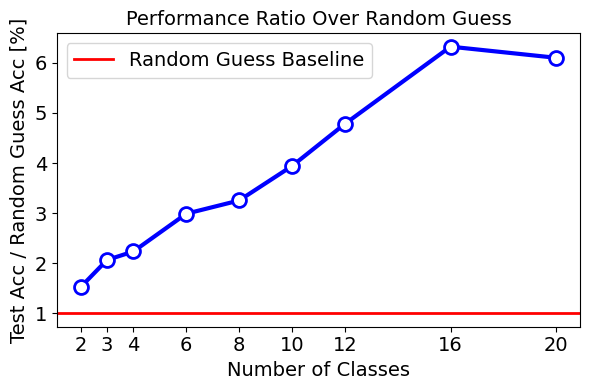

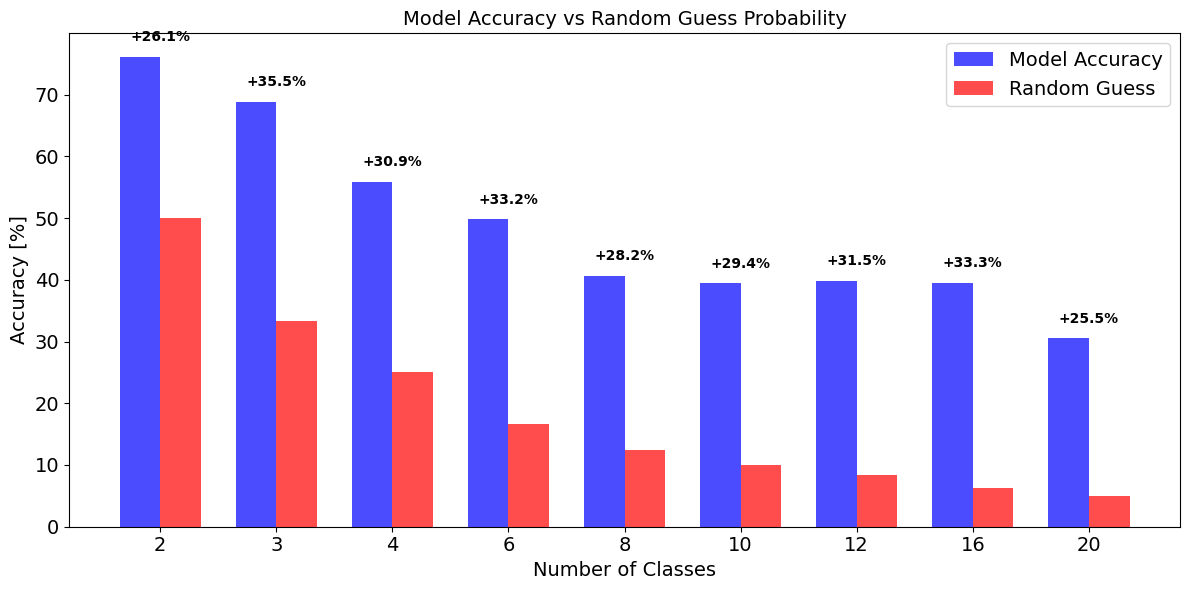

In [6]:
# Define the bin configurations
bin_configs = [2, 3, 4, 6, 8, 10, 12, 16, 20]
results = {}

# Run experiments for all bin configurations
for num_bins in bin_configs:
    results[num_bins] = run_experiment(num_bins)

# Plot all results together
plot_all_results(results)